In [1]:
import EoN
import numpy as np
import networkx as nx
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import random

from tqdm.autonotebook import tqdm
import time

plt.style.use('seaborn-white')
sns.set_style("ticks")
sns.set_context("talk")
%matplotlib inline

/Users/agarbuno/anaconda2/envs/risknet/lib/python3.6/site-packages/ipykernel_launcher.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  if __name__ == '__main__':


In [2]:
import sys
sys.path.append('/Users/agarbuno/github-repos/collaborations/covid/risk-networks/risknet')

In [3]:
%load_ext autoreload
%autoreload 2
import epimodels

In [4]:
N = 1000
# G = nx.fast_gnp_random_graph(N, 5./(N-1))
G = nx.powerlaw_cluster_graph(N, 20, 5./(N-1))

In [5]:
# edge_list = np.loadtxt('../data/networks/High-School_data_2013.csv', usecols = [1,2], dtype = int) 
# # # edge_list = np.loadtxt('networks/thiers_2012.csv', usecols = [1,2], dtype = int) 

# # G = nx.Graph([tuple(k) for k in edge_list])
# # G = nx.relabel_nodes(G,dict(zip(list(G.nodes()), range(len(list(G.nodes()))))))

# # N = len(list(G.nodes))
# # # N = np.array(list(G.nodes())).max() + 1

In [6]:
net_size = '1e3'
edge_list = np.loadtxt('../data/networks/edge_list_SBM_%s.txt'%net_size, usecols = [0,1], dtype = int, skiprows = 1) 
G = nx.Graph([tuple(k) for k in edge_list])
N = len(list(G.nodes))

# G = nx.relabel_nodes(G,dict(zip(list(G.nodes()), range(len(list(G.nodes()))))))
# N = np.array(list(G.nodes())).max() + 1

In [7]:
classes = ['hospital', 'healthcare', 'city']
classes_range = [range(int(float(net_size) * 0.005)), 
                 range(int(float(net_size) * 0.005), int(float(net_size) * 0.045)), 
                 range(int(float(net_size) * 0.045), N)]

cohort = defaultdict()
for node in G.nodes:
    if node in classes_range[0]:
        cohort[node] = {'cohort': classes[0]}
    elif node in classes_range[1]:
        cohort[node] = {'cohort': classes[1]}
    else:
        cohort[node] = {'cohort': classes[2]}

In [8]:
nx.set_node_attributes(G, cohort)

(array([921.,  23.,   6.,   1.,   3.,   1.,   3.,   1.,   0.,   1.]),
 array([  2. ,  47.4,  92.8, 138.2, 183.6, 229. , 274.4, 319.8, 365.2,
        410.6, 456. ]),
 <a list of 10 Patch objects>)

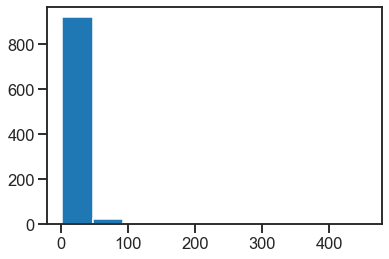

In [9]:
plt.hist(np.array(list(dict(G.degree).values())))

In [10]:
epistatic = epimodels.static(G, N)

In [11]:
epistatic.init(beta = 0.04)

In [12]:
# infected = range(200)
infected = np.random.randint(N, size = 50)
infected = np.random.randint(classes_range[-1][0], classes_range[-1][-1], size = 50)
epistatic.init_infected(infected)

In [13]:
nsims = 50
sims  = []

return_statuses = ('S', 'E', 'I', 'H', 'R', 'D')

for kk in tqdm(np.arange(nsims), desc = 'Simulations'):
    sim = epistatic.simulate(return_statuses)
    sims.append(sim)

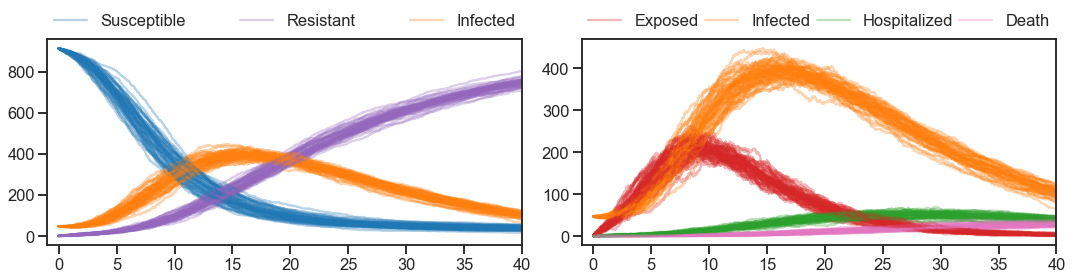

In [14]:
fig, axes = plt.subplots(1, 2, figsize = (15, 4))
alpha = .32


for sim in tqdm(sims, desc = 'Simulations'):
    times, states = sim.summary()
    axes[0].plot(times, states['S'], color = 'C0', alpha = alpha)
    axes[0].plot(times, states['R'], color = 'C4', alpha = alpha)
    axes[0].plot(times, states['I'], color = 'C1', alpha = alpha)

    axes[1].plot(times, states['E'], color = 'C3', alpha = alpha)
    axes[1].plot(times, states['I'], color = 'C1', alpha = alpha)
    axes[1].plot(times, states['H'], color = 'C2', alpha = alpha)
    axes[1].plot(times, states['D'], color = 'C6', alpha = alpha)

axes[0].legend(['Susceptible', 'Resistant', 'Infected'], 
               bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=3, mode="expand", borderaxespad=0.);
axes[1].legend(['Exposed', 'Infected', 'Hospitalized', 'Death'], 
              bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
              ncol=4, mode="expand", borderaxespad=0.);

for ax in axes:
    ax.set_xlim(-1, 40)

plt.tight_layout()

In [15]:
np.percentile(np.diff(sim.t()), q = [5, 25, 50, 75, 95])

array([0.00053623, 0.0034969 , 0.00888819, 0.02083832, 0.09254325])

In [16]:
E, I, H, R, D = np.zeros([5, N])
S = np.ones(N,)
I[infected] = 1.
S[infected] = 0.

In [17]:
y0 = np.hstack((S, E, I, H, R, D))
T = 300
t = np.linspace(0,T,201)

In [18]:
start_time = time.time()

epistatic.set_solver(T = T, dt = 30.)
ke = epistatic.solve(y0, t)

elapsed_time = time.time() - start_time
tqdm.write('Runtime: ' + time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Runtime: 00:00:01


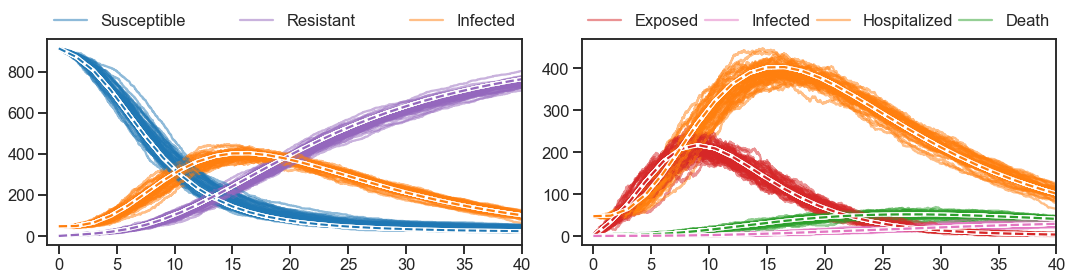

In [19]:
fig, axes = plt.subplots(1, 2, figsize = (15, 4))

alpha = .5

for sim in tqdm(sims, desc = 'Simulations'):
    times, states = sim.summary()
    axes[0].plot(times, states['S'], color = 'C0', alpha = alpha)
    axes[0].plot(times, states['R'], color = 'C4', alpha = alpha)
    axes[0].plot(times, states['I'], color = 'C1', alpha = alpha)
    
    axes[0].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[0], color = 'white', linestyle = '-', linewidth = 4)
    axes[0].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[0], color = 'C0', linestyle = '--', linewidth = 2)
    axes[0].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[-2], color = 'white', linestyle = '-', linewidth = 4)
    axes[0].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[-2], color = 'C4', linestyle = '--')
    axes[0].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[2], color = 'white', linestyle = '-', linewidth = 4)
    axes[0].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[2], color = 'C1', linestyle = '--')
    
    axes[1].plot(times, states['E'], color = 'C3', alpha = alpha)
    axes[1].plot(times, states['D'], color = 'C6', alpha = alpha)
    axes[1].plot(times, states['I'], color = 'C1', alpha = alpha)
    axes[1].plot(times, states['H'], color = 'C2', alpha = alpha)
    
    axes[1].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[1], color = 'white', linestyle = '-', linewidth = 4)
    axes[1].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[1], color = 'C3', linestyle = '--')
    axes[1].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[2], color = 'white', linestyle = '-', linewidth = 4)
    axes[1].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[2], color = 'C1', linestyle = '--')
    axes[1].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[-3], color = 'white', linestyle = '-', linewidth = 4)
    axes[1].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[-3], color = 'C2', linestyle = '--')
    axes[1].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[-1], color = 'white', linestyle = '-', linewidth = 4)
    axes[1].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[-1], color = 'C6', linestyle = '--')
    
axes[0].legend(['Susceptible', 'Resistant', 'Infected'], 
               bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=3, mode="expand", borderaxespad=0.);
axes[1].legend(['Exposed', 'Infected', 'Hospitalized', 'Death'], 
              bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
              ncol=4, mode="expand", borderaxespad=0.);
    
for ax in axes:
    ax.set_xlim(-1, 40)
    
plt.tight_layout()

In [20]:
tqdm.write('Number of probabilities exceeding upper bound: %s'%(ke.y.reshape(6,-1,201).max(axis = 0) > 1.0).sum())

Number of probabilities exceeding upper bound: 0


In [21]:
states = ['Susceptible', 'Exposed', 'Infected', 'Hospitalized', 'Resistant', 'Dead']
colors = ['C0', 'C3', 'C1', 'C2', 'C4', 'C6']

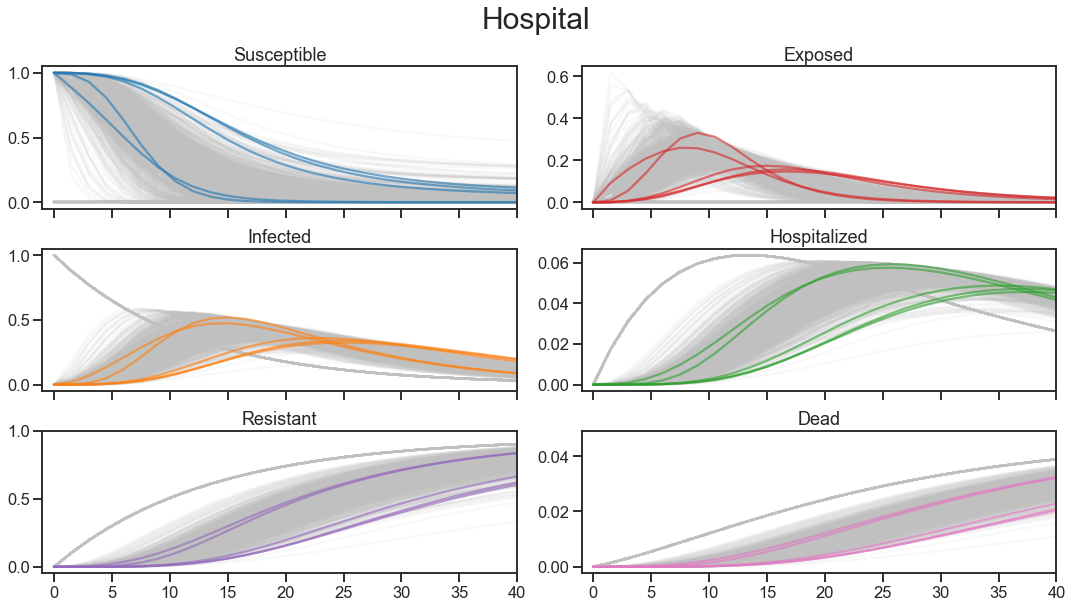

In [22]:
fig, axes = plt.subplots(3, 2, figsize = (15, 8), sharex = True, sharey = False)

alpha = .1

# for mm in tqdm(range(6), desc = 'Simulations'):
for state, ax in tqdm(enumerate(axes.flatten()), total = 6):
    ax.plot(ke.t, ke.y.reshape(6,-1,len(t))[state].T, alpha = alpha, color = 'silver');
    ax.plot(ke.t, ke.y.reshape(6,-1,len(t))[state].T[:,classes_range[0]], alpha = alpha + .5, color = colors[state]);
    ax.set_title(states[state])
    ax.set_xlim(-1, 40)

plt.suptitle('Hospital', fontsize = 30, y =  1.05)
plt.tight_layout()

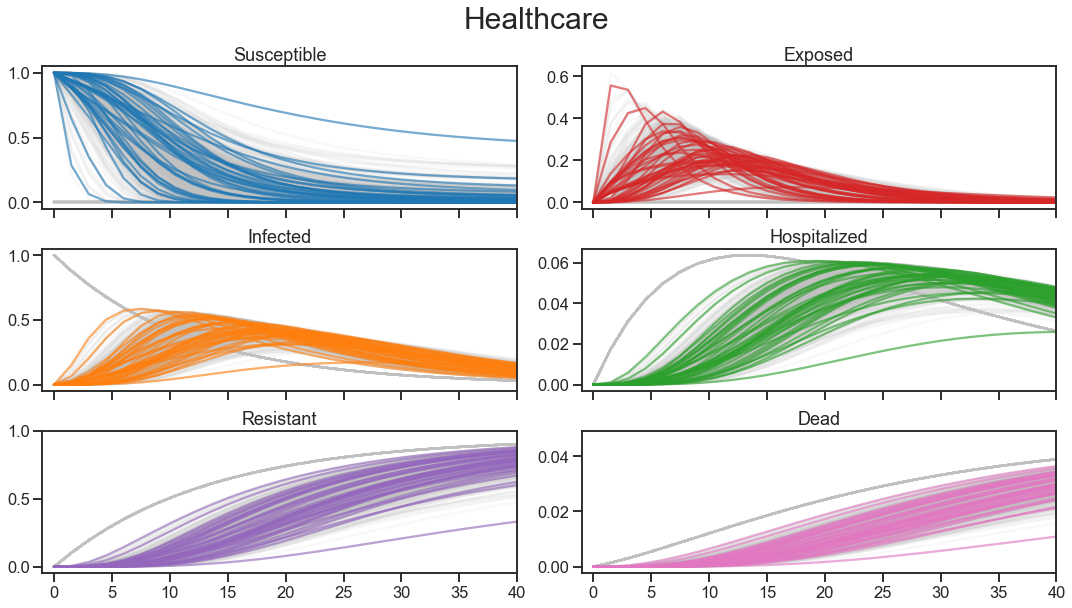

In [23]:
fig, axes = plt.subplots(3, 2, figsize = (15, 8), sharex = True, sharey = False)

alpha = .1

# for mm in tqdm(range(6), desc = 'Simulations'):
for state, ax in tqdm(enumerate(axes.flatten()), total = 6):
    ax.plot(ke.t, ke.y.reshape(6,-1,len(t))[state].T, alpha = alpha, color = 'silver');
    ax.plot(ke.t, ke.y.reshape(6,-1,len(t))[state].T[:,classes_range[1]], alpha = alpha + .5, color = colors[state]);
    ax.set_title(states[state])
    ax.set_xlim(-1, 40)
    
plt.suptitle('Healthcare', fontsize = 30, y =  1.05)

plt.tight_layout()

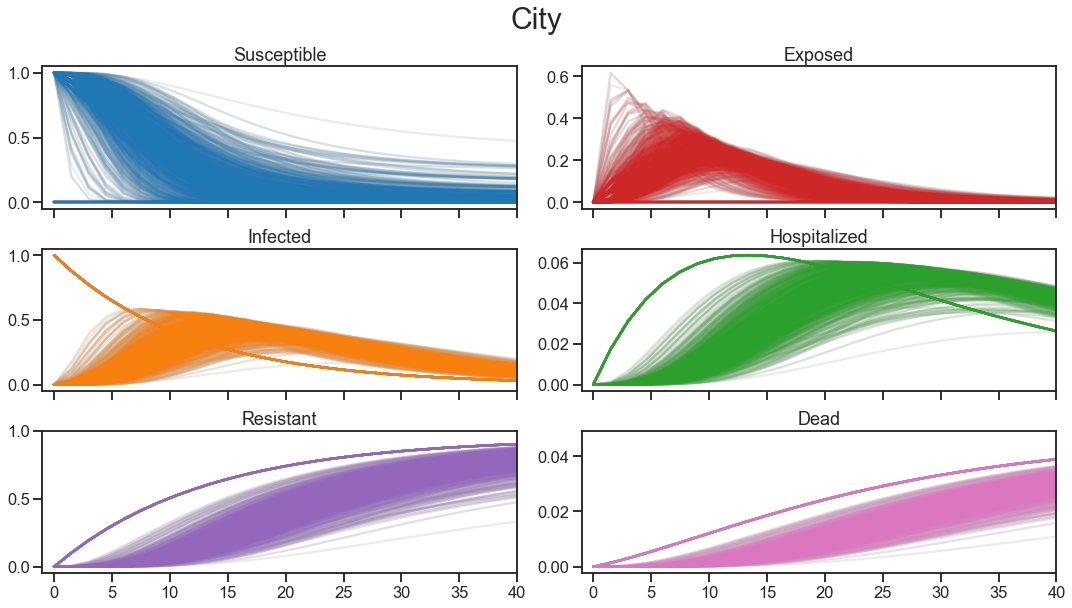

In [24]:
fig, axes = plt.subplots(3, 2, figsize = (15, 8), sharex = True, sharey = False)

alpha = .1

# for mm in tqdm(range(6), desc = 'Simulations'):
for state, ax in tqdm(enumerate(axes.flatten()), total = 6):
    ax.plot(ke.t, ke.y.reshape(6,-1,len(t))[state].T, alpha = alpha + .2, color = 'silver');
    ax.plot(ke.t, ke.y.reshape(6,-1,len(t))[state].T[:,classes_range[2]], alpha = alpha, color = colors[state]);
    ax.set_title(states[state])
    ax.set_xlim(-1, 40)

plt.suptitle('City', fontsize = 30, y =  1.05)
    
plt.tight_layout()